In [1]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

In [4]:
with open("./Data/Data.csv", "r") as f:
    reader = csv.reader(f)
    data = list(reader)
classes = [int(i[1]) for i in data if i[2] == "test"]

CLASS_WEIGHTS = compute_class_weight("balanced", classes=np.unique(classes), y=classes)
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS, dtype=torch.float)
len(classes)

2747

In [5]:
PROTEIN_LETTERS = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'P':14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19, 'V':20, 'W':21, 'Y':22, 'X':23, 'Z':24}

class protein_sequence_ds(Dataset):
    def __init__(self, csv_path, split):
        self.csv_path = csv_path
        with open(self.csv_path) as f:
            reader = csv.reader(f)
            data = list(reader)
        self.split = split
        if split == 'train':
            self.data = [i for i in data if i[2]=="train"]
        elif split == 'test':
            self.data = [i for i in data if i[2]=="test"]
        self.feats = np.load("Data/esm_feats.npy", allow_pickle=True).item()
        
    def __getitem__(self, index):
        feats = self.feats[self.data[index][0]]
        label = self.data[index][1]
        return torch.from_numpy(feats[0]), int(label)
    
    def __len__(self):
        return len(self.data)
        

In [6]:
class seq_model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(seq_model, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_size, 2048),
                      nn.ReLU(),

                      nn.Linear(2048, 1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),

                      nn.Linear(1024, 512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),

                      nn.Linear(512, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),

                      nn.Linear(256, 128),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),

                      nn.Linear(128, num_classes),
                      nn.Softmax())
    
    def forward(self, x):
        return self.model(x)


In [7]:
model = seq_model(1280, 10)

In [8]:
batch_size = 256
train_ds = protein_sequence_ds('./Data/Data.csv', 'train')
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [9]:
# criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000004)

In [13]:
test_ds = protein_sequence_ds('./Data/Data.csv', 'test')
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=120, shuffle=False)
top_acc = 0
def eval(cf=False):
    model.eval()
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
        with torch.no_grad():
            output = model(inputs.cuda()) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = (1,2,3,4,5,6,7,8,9,10)
    if(not confusion_matrix):
        return 100*sum(np.array(y_true) == np.array(y_pred))/len(y_true)
    #Build confusion matrix
    else:
        cf_matrix = confusion_matrix(y_true, y_pred)
        return 100*sum(np.array(y_true) == np.array(y_pred))/len(y_true), cf_matrix


In [11]:
model.cuda()
criterion.cuda()

device = torch.device("cuda:0")
for epoch in range(50):
    model.train()
    running_loss = 0.0
    curr_corr = 0.0
    ctr = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, target in tepoch:
            ctr += 1
            model.train()
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            loss = criterion(output, target)
            correct = (predictions == target).sum().item()
            accuracy = correct / batch_size
            curr_corr += correct
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=running_loss/(batch_size*ctr), accuracy=curr_corr/(batch_size*ctr))
    acc = eval()
    if acc > top_acc:
        print("Accuracy improved from {} to {}".format(top_acc, acc))
        top_acc = acc
        torch.save(model, "esm_model.pt")    

Epoch 0:   0%|          | 0/43 [00:00<?, ?batch/s]C:\Users\Dinesh Sathia Raj\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch 0: 100%|██████████| 43/43 [00:03<00:00, 12.29batch/s, accuracy=0.212, loss=0.00885]


Accuracy improved from 0 to 19.038951583545686


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 82.10batch/s, accuracy=0.346, loss=0.00862]


Accuracy improved from 19.038951583545686 to 40.04368401892974


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 88.59batch/s, accuracy=0.464, loss=0.00844]


Accuracy improved from 40.04368401892974 to 49.14452129595923


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 93.50batch/s, accuracy=0.536, loss=0.00829]


Accuracy improved from 49.14452129595923 to 55.07826720058245


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 82.41batch/s, accuracy=0.578, loss=0.00816]


Accuracy improved from 55.07826720058245 to 58.09974517655624


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 75.58batch/s, accuracy=0.611, loss=0.00805]


Accuracy improved from 58.09974517655624 to 61.99490353112486


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 90.91batch/s, accuracy=0.631, loss=0.00796]


Accuracy improved from 61.99490353112486 to 64.25191117582817


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 88.33batch/s, accuracy=0.646, loss=0.00788]


Accuracy improved from 64.25191117582817 to 65.63523844193666


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 94.39batch/s, accuracy=0.658, loss=0.00781]


Accuracy improved from 65.63523844193666 to 66.5453221696396


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 91.69batch/s, accuracy=0.67, loss=0.00775] 


Accuracy improved from 66.5453221696396 to 67.60101929377502


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 92.20batch/s, accuracy=0.681, loss=0.0077] 


Accuracy improved from 67.60101929377502 to 68.72952311612669


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 90.99batch/s, accuracy=0.688, loss=0.00765]


Accuracy improved from 68.72952311612669 to 69.5668001456134


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 90.81batch/s, accuracy=0.698, loss=0.0076] 


Accuracy improved from 69.5668001456134 to 70.25846377866763


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 87.49batch/s, accuracy=0.706, loss=0.00756]


Accuracy improved from 70.25846377866763 to 70.76811066618129


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 91.18batch/s, accuracy=0.718, loss=0.00751]


Accuracy improved from 70.76811066618129 to 71.4233709501274


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 82.92batch/s, accuracy=0.728, loss=0.00747]


Accuracy improved from 71.4233709501274 to 72.29705132872225


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 89.70batch/s, accuracy=0.736, loss=0.00744]


Accuracy improved from 72.29705132872225 to 73.06152165999272


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 87.01batch/s, accuracy=0.746, loss=0.0074] 


Accuracy improved from 73.06152165999272 to 74.0444120859119


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 87.55batch/s, accuracy=0.752, loss=0.00737]


Accuracy improved from 74.0444120859119 to 74.69967236985802


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 92.08batch/s, accuracy=0.761, loss=0.00733]


Accuracy improved from 74.69967236985802 to 74.77247906807426


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 92.06batch/s, accuracy=0.766, loss=0.0073] 


Accuracy improved from 74.77247906807426 to 75.31852930469603


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 100.32batch/s, accuracy=0.773, loss=0.00727]


Accuracy improved from 75.31852930469603 to 75.8645795413178


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 90.65batch/s, accuracy=0.778, loss=0.00724]


Accuracy improved from 75.8645795413178 to 76.4834364761558


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 91.35batch/s, accuracy=0.784, loss=0.00721]


Accuracy improved from 76.4834364761558 to 76.92027666545322


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 82.42batch/s, accuracy=0.787, loss=0.00718]


Accuracy improved from 76.92027666545322 to 77.53913360029122


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 86.67batch/s, accuracy=0.793, loss=0.00715]


Accuracy improved from 77.53913360029122 to 77.79395704404806


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 88.70batch/s, accuracy=0.8, loss=0.00713]  


Accuracy improved from 77.79395704404806 to 78.23079723334547


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 91.44batch/s, accuracy=0.805, loss=0.00711]


Accuracy improved from 78.23079723334547 to 78.37641062977794


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 92.91batch/s, accuracy=0.806, loss=0.00708]


Accuracy improved from 78.37641062977794 to 78.48562067710229


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 84.95batch/s, accuracy=0.812, loss=0.00706]


Accuracy improved from 78.48562067710229 to 78.81325081907535


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 94.20batch/s, accuracy=0.815, loss=0.00703]


Accuracy improved from 78.81325081907535 to 79.03167091372406


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 92.86batch/s, accuracy=0.82, loss=0.00701] 


Accuracy improved from 79.03167091372406 to 79.1044776119403


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 96.89batch/s, accuracy=0.823, loss=0.00699]


Accuracy improved from 79.1044776119403 to 79.21368765926465


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 90.77batch/s, accuracy=0.826, loss=0.00697]


Accuracy improved from 79.21368765926465 to 79.39570440480524


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 92.64batch/s, accuracy=0.831, loss=0.00695]


Accuracy improved from 79.39570440480524 to 79.57772115034584


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 97.19batch/s, accuracy=0.836, loss=0.00691]


Accuracy improved from 79.57772115034584 to 79.65052784856206


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 89.19batch/s, accuracy=0.844, loss=0.00685]


Accuracy improved from 79.65052784856206 to 79.83254459410266


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 97.76batch/s, accuracy=0.847, loss=0.00683]


Accuracy improved from 79.83254459410266 to 80.05096468875136


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 93.85batch/s, accuracy=0.849, loss=0.00681]


Accuracy improved from 80.05096468875136 to 80.1237713869676


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 93.35batch/s, accuracy=0.851, loss=0.0068] 


Accuracy improved from 80.1237713869676 to 80.19657808518383


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 88.34batch/s, accuracy=0.855, loss=0.00678]


Accuracy improved from 80.19657808518383 to 80.23298143429196


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 86.52batch/s, accuracy=0.865, loss=0.0067] 


Accuracy improved from 80.23298143429196 to 80.30578813250818


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 90.05batch/s, accuracy=0.866, loss=0.00669]


C:\Users\Dinesh Sathia Raj\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<AxesSubplot:>

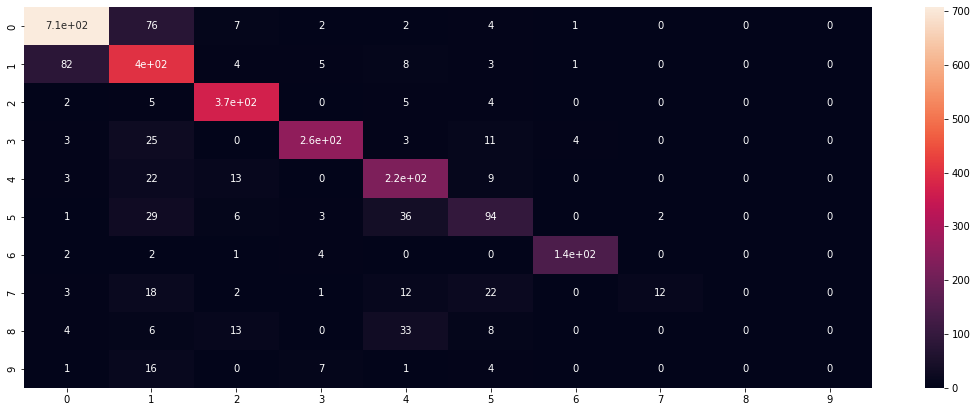

In [14]:
model=torch.load("esm_model.pt")
acc, cf = eval(cf=True)
plt.figure(figsize = (19, 7))
sn.heatmap(cf, annot=True)